In [1]:
import os
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# need to sort by distance here before i bring to the vaestar train

# VAEStar

COnstruct a variational autoencoder to infer stellar parameters. We take the cluster that we found from the membership probability part of the problem in order to test the model.

/var/folders/v8/qszwt8g90wj00vpb5s08vpdw0000gn/T/ipykernel_97342/941303352.py:3: DtypeWarning: Columns (11,12,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  cluster_df=pd.read_csv('cluster_members_final.csv')


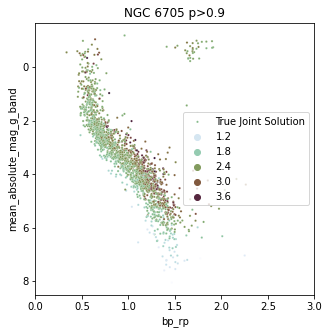

In [2]:
# Data input, take in the cluster and plot the memebrs
os.chdir("Data")
cluster_df=pd.read_csv('cluster_members_final.csv')
os.chdir("../")


probability='p3'
f, axes = plt.subplots(1, 1)
f.set_figheight(5)
f.set_figwidth(5)

cluster_df=cluster_df[cluster_df['phot_bp_mean_flux_error']<1000].reset_index(drop=True)

scatter=cluster_df[cluster_df[probability]>0.9]


sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],hue=scatter['rgeo'],s=5,ax=axes,label='True Joint Solution',color='b', palette="ch:r=1,l=1.0")
axes.invert_yaxis()
plt.legend()
axes.set_title("NGC 6705 p>0.9")
plt.xlim(0,3)
plt.show()


scatter=scatter[scatter['rgeo']>=1.8].reset_index(drop=True)
scatter=scatter[scatter['rgeo']<=2.5].reset_index(drop=True)
#scatter=scatter[scatter['bp_rp']<=1.6].reset_index(drop=True)

orig_scatter=scatter

orig_scatter['rgeo']=scatter['rgeo'].median() #still assuming everything at the same distance
#set the main distance.
orig_scatter['rgeo']=2.0

cluster_df=scatter

Select the relevant columns

In [3]:
cluster_df=cluster_df[['ra','dec','parallax','phot_g_mean_mag','phot_g_mean_flux','phot_rp_mean_flux','phot_bp_mean_flux','phot_bp_mean_mag','phot_rp_mean_mag','bp_rp','mean_absolute_mag_g_band','ra_error','dec_error','parallax_error','phot_g_mean_flux_error','phot_bp_mean_flux_error','phot_rp_mean_flux_error']].reset_index(drop=True)



# Photometric Errors

Gaia recommends some changes to the photometric errors, see the documentation. I'm not sure the effect on different Gaia releases.

In [4]:
cluster_df['phot_g_mean_mag_error']=np.sqrt(((2.5/np.log(10))*cluster_df['phot_g_mean_flux_error']/cluster_df['phot_g_mean_flux'])**2+0.0027553202**2)
cluster_df['bp_error']=np.sqrt(((2.5/np.log(10))*cluster_df['phot_bp_mean_flux_error']/cluster_df['phot_bp_mean_flux'])**2+0.0037793818**2)
cluster_df['rp_error']=np.sqrt(((2.5/np.log(10))*cluster_df['phot_rp_mean_flux_error']/cluster_df['phot_rp_mean_flux'])**2+0.0027901700**2)
cluster_df['bp_rp_error']=np.sqrt(cluster_df['rp_error']**2+cluster_df['bp_error']**2)

# Feature scaling might be important 

However, we can (I think) just untransform before the likelihood is done. Provided Pytorch allows us to propegate backwards through a scaling operation. I suppose we can actually just do manual scaling using Pytorch operations for MinMaxScaler and that would be fine.

# Data format

(batch size, sequence length, input dimension)
LSTMs learn ? over a longer period of time so my distance data will be batch_size, 1, 1,.

Circular lstm kind of thing? Anyway for now we say the only long term memory that is needed is the distance. Ra and Dec is somehting there but thats a local correlation and I'll try include that in the error function


# Draw instances of each row.

We will draw instances from a Gaussian of each row to simulate the error in our data. This will then be fed into the VAE to get a MCMC estimate of the latent variables.

#### Prior on Distance

In general, we will need some sort of prior on distances. In this problem our distances are fairly ok regarding error so I will just invert the parallax as the distance.

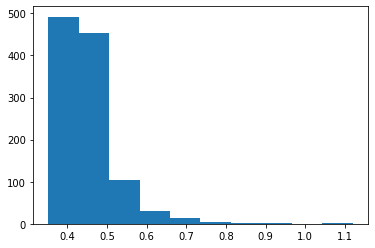

In [5]:
plt.hist(cluster_df['parallax'])
plt.show()

# Normal distribution draws

Eventually should put in the cross correlations but for now isotropic. The draws will be used later on training.

In [6]:
mean_x=cluster_df[['ra','dec','parallax','phot_g_mean_mag','bp_rp']].to_numpy()
var_x=cluster_df[['ra_error','dec_error','parallax_error','phot_g_mean_mag_error','bp_rp_error']].to_numpy()**2

### Here we make the draws and put the data into a new dataframe.

In [7]:
x_params=[]
x_var=[]
draw_size=32 
for i in range (len(mean_x)):
    mu=mean_x[i]
    sig=np.diag(var_x[i])
    draws = np.random.multivariate_normal(mu, sig, size=draw_size)

    x_params.append(draws)
    x_var.append(np.tile(sig,(draw_size,1)))



x_params=np.array(x_params)
x_params=x_params.reshape((x_params.shape[0]*x_params.shape[1],x_params.shape[2]))

x_var=np.array(x_var)
x_var=x_var.reshape((x_var.shape[0]*x_var.shape[1],x_var.shape[2]))

resampled_x=pd.DataFrame(data=x_params,columns=[['ra','dec','parallax','phot_g_mean_mag','bp_rp']])
resampled_err=pd.DataFrame(data=x_params,columns=[['ra_error','dec_error','parallax_error','phot_g_mean_mag_error','bp_rp_error']])
resampled_x['ra']=resampled_x['ra']%360
resampled_x['dec']=resampled_x['dec']%360

### Turn the apperant mag into absolute mag

In [8]:
def mean_basolute_mag_g_band(selection_gaia):

    return selection_gaia['phot_g_mean_mag'].values+5*np.log10(selection_gaia['parallax'].values/1000)+5
    

resampled_x['G']=mean_basolute_mag_g_band(resampled_x)
cluster_df['G']=mean_basolute_mag_g_band(cluster_df)
x_resample=pd.concat([resampled_x,resampled_err],axis=1)

/var/folders/v8/qszwt8g90wj00vpb5s08vpdw0000gn/T/ipykernel_97342/3818395397.py:3: RuntimeWarning: invalid value encountered in log10
  return selection_gaia['phot_g_mean_mag'].values+5*np.log10(selection_gaia['parallax'].values/1000)+5


Overview of the resampled dataframe

The dropna could cause issues for the MCMC of z later on.

In [11]:
os.chdir("Data")
x_input=cluster_df[['ra','dec','parallax','phot_g_mean_mag','bp_rp','G']]
x_input_err=cluster_df[['ra_error','dec_error','parallax_error','phot_g_mean_mag_error','bp_rp_error']]


In [13]:

x_input.to_csv('x_input')
x_input_err.to_csv('x_input_err')


In [9]:
x_resample

,ra,dec,parallax,phot_g_mean_mag,bp_rp,G,ra_error,dec_error,parallax_error,phot_g_mean_mag_error,bp_rp_error
0,282.617623,353.736072,0.523195,16.403768,1.096704,4.997085,282.617623,-6.263928,0.523195,16.403768,1.096704
1,282.613973,353.707833,0.429590,16.401640,1.101808,4.566911,282.613973,-6.292167,0.429590,16.401640,1.101808
2,282.622243,353.720662,0.594859,16.399872,1.083269,5.271943,282.622243,-6.279338,0.594859,16.399872,1.083269
3,282.605223,353.731249,0.459506,16.403757,1.108842,4.715214,282.605223,-6.268751,0.459506,16.403757,1.108842
4,282.635144,353.659076,0.494497,16.397372,1.107701,4.868189,282.635144,-6.340924,0.494497,16.397372,1.107701
...,...,...,...,...,...,...,...,...,...,...,...
35227,282.840354,354.071443,0.669144,17.492610,1.659102,6.620209,282.840354,-5.928557,0.669144,17.492610,1.659102
35228,282.788486,354.006582,0.559428,17.501377,1.638460,6.240098,282.788486,-5.993418,0.559428,17.501377,1.638460
35229,282.917113,353.766585,0.394963,17.496963,1.628077,5.479747,282.917113,-6.233415,0.394963,17.496963,1.628077
35230,282.840556,354.025269,0.492562,17.499215,1.697197,5.961518,282.840556,-5.974731,0.492562,17.499215,1.697197


In [10]:
#x_resample=x_resample.dropna().reset_index(drop=True)

# Isochrone preparing

The goal here is to derive the likelihood function easily.

In [11]:
import minimint

In [12]:
filters = ["Gaia_G_EDR3", "Gaia_BP_EDR3", 'Gaia_RP_EDR3']
ii = minimint.Interpolator(filters)


# Variational Autoencoder

# Prior $P(z)$



Find nearest will return the isochrone with the closest values of the latent variables. The prior will ensure that the value of the latent variables stay within their physical bounds.

In [13]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx

def isochrone_selector(feh,age):
    '''if(feh<-4 or feh>0.5):
        raise NotImplementedError
    if(age<5 or age>10.3):
        raise NotImplementedError
    else:'''
    logagegrid = np.linspace(5,10.3,105)
    fehgrid = np.linspace(-4,0.5,90)
    feh,feh_idx=find_nearest(fehgrid,feh)
    age,age_idx=find_nearest(logagegrid,age)

    return feh_idx*len(logagegrid)+age_idx

# Likelihood function $P(x|z)$
Given our sample of $z$ - the extinction, age and metalicity, our likelihood will be defined as the perpendicular distance from the isochrone. 
Build a CSV of all the possible isochrones.

In [14]:
massgrid = 10*np.linspace(np.log10(0.1),np.log10(10), 1000)
logagegrid = np.linspace(5,10.3,105)
fehgrid = np.linspace(-4,0.5,90)
dfs=[]
for feh in fehgrid:
    for lage in logagegrid:
        iso = pd.DataFrame(ii(massgrid, lage, feh))
        dfs.append(iso[iso['phase']==0].reset_index(drop=True))
    

(20.0, -15.0)

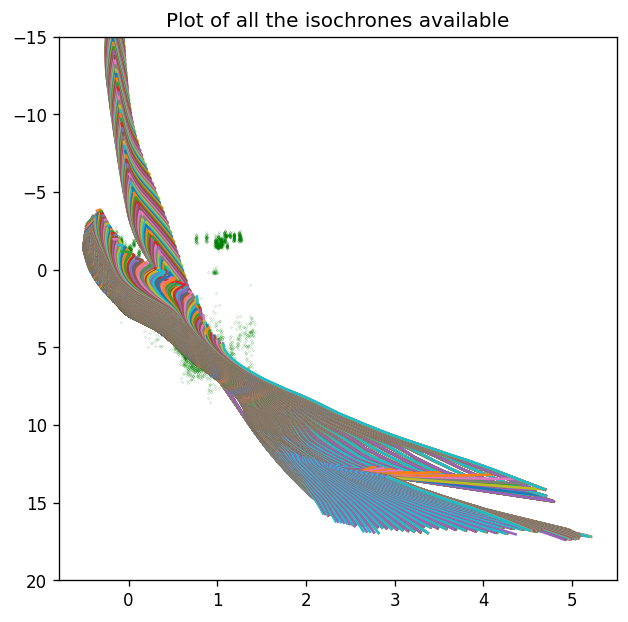

In [15]:
fig = plt.figure(figsize=(6, 6), dpi=120)
for isochrone in dfs:
    plt.plot(isochrone['Gaia_BP_EDR3']-isochrone['Gaia_RP_EDR3'], isochrone['Gaia_G_EDR3'],
                    )
    
    
plt.scatter(resampled_x['bp_rp']-0.65,resampled_x['G']-1.1,color='g',s=0.01)
plt.title('Plot of all the isochrones available')
plt.ylim(20, -15)

### Find local tangents to the isochrone, and their perpendicular slopes.

In [16]:
for isochrone in dfs:
    p_slopes=[]
    isochrone['BPRP']=isochrone['Gaia_BP_EDR3']-isochrone['Gaia_RP_EDR3']
    x=isochrone['BPRP']
    y=isochrone['Gaia_G_EDR3']
    
    for i in range(len(isochrone)-1):    
        dy=y[i+1]-y[i]
        dx=x[i+1]-x[i]
        p_slopes.append(-1*dx/dy)
    p_slopes.append(0)

    isochrone['p_slopes']=p_slopes
    isochrone['slopes']=-1/isochrone['p_slopes']

    high_c=[]
    low_c=[]
    for i in range(len(isochrone)-1):
        high_c.append(isochrone['Gaia_G_EDR3'][i+1] - isochrone['p_slopes'][i]*isochrone['BPRP'][i+1])
        low_c.append(isochrone['Gaia_G_EDR3'][i] - isochrone['p_slopes'][i]*isochrone['BPRP'][i])
    high_c.append(0)
    low_c.append(0)
    isochrone['low_c']=high_c #high c is low c oops
    isochrone['high_c']=low_c
    isochrone=isochrone[:-2]
    

### The next function allows us to use the name of the columns and return the tensor index.

In [17]:
def column_index(name):
    if name in cluster_df.columns:
        return np.where(np.array(cluster_df.columns)==name)[0][0]
    else:
        return np.where(np.array(dfs[0].columns)==name)[0][0] +len(cluster_df.columns)

### Given $z$, we wish to select the relevant isochrone and create a data cube which will allow tensor calculations.

In [18]:
import torch
tens=[]
lengths=[]
for isochrone in dfs:
    isoc=torch.tensor(isochrone.values).reshape((1,isochrone.shape[1],isochrone.shape[0]))
    tens.append(isoc)
    lengths.append(isoc.shape[-1])

x_values=cluster_df.values
x_values=torch.tensor(x_values)
x_values=x_values.reshape((x_values.shape[0],x_values.shape[1],1))
import torch.nn.functional as F
pad_size=np.max(lengths)


stack_tens=[]
for i in range(len(tens)):
    t=F.pad(input=tens[i], pad=(0,pad_size-tens[i].shape[-1]), value=torch.nan)
    stack_tens.append(t.reshape(t.shape[1:]))


In [19]:
stacked_isochrones=torch.stack(stack_tens)
x_values=x_values.expand(x_values.shape[0],x_values.shape[1],pad_size)


# Export data

The data being exported here are stacked isochrones and the cluster data. We have functions to find the column names and the isochrone.

In [20]:
import pickle
os.chdir("Data")

t_np = stacked_isochrones.numpy() #convert to Numpy array
#output=open('isochrones.pkl','wb') #convert to a dataframe
#pickle.dump(t_np,output) #save to file

t_np = x_values.numpy() #convert to Numpy array
#output=open('x_values.pkl','wb') #convert to a dataframe
#pickle.dump(t_np,output)#save to file

In [21]:
t_np = np.array(cluster_df.columns) #convert to Numpy array
#output=open('columns.pkl','wb') #convert to a dataframe
#pickle.dump(t_np,output)#save to file

In [22]:
t_np = np.array(dfs[0].columns).astype(str) #convert to Numpy array
#output=open('isoc_cols.pkl','wb') #convert to a dataframe
#pickle.dump(t_np,output)#save to file


# ------

In [ ]:
isochrone=practice.reshape((1,)+practice.shape)
#x.shape
#e=torch.tensor([i for i in range(92)]).repeat(len(x),1)
#x[:,column_index('G'),:]+e
truth_1=(isochrone[:,column_index('G'),:]-isochrone[:,column_index('bp_rp'),:]*isochrone[:,column_index('p_slopes'),:]<=isochrone[:,column_index('high_c'),:])

truth_1=truth_1.reshape(truth_1.shape[0],1,truth_1.shape[1])

truth_2=(isochrone[:,column_index('low_c'),:]<=isochrone[:,column_index('G'),:]-isochrone[:,column_index('bp_rp'),:]*isochrone[:,column_index('p_slopes'),:])
truth_2=truth_2.reshape(truth_2.shape[0],1,truth_2.shape[1])

truth=truth_1*truth_2




x=((1/torch.sqrt(1+isochrone[:,column_index('slopes'),:]**2))*(isochrone[:,column_index('G'),:]-isochrone[:,column_index('bp_rp'),:]*isochrone[:,column_index('slopes'),:]-isochrone[:,column_index('Gaia_G_EDR3'),:] + isochrone[:,column_index('slopes'),:]*isochrone[:,column_index('BPRP'),:]))



idx=torch.argmin(torch.abs(x/truth.reshape(x.shape)).nan_to_num(nan=torch.inf),1)

x=x.gather(1,idx.view(-1,1))
#error needs to be corrected
x_err=(1/(1+isochrone[:,column_index('slopes'),:]**2))*isochrone[:,column_index('phot_g_mean_mag_error'),:]**2+(isochrone[:,column_index('slopes'),:]*isochrone[:,column_index('bp_rp_error'),:])**2
x_err=x_err.gather(1,idx.view(-1,1))

isochrone=torch.cat((isochrone,x.reshape(x.shape[0],1,x.shape[1]).repeat(1,1,(isochrone).shape[-1]),x_err.reshape(x_err.shape[0],1,x_err.shape[1]).repeat(1,1,(isochrone).shape[-1])),1)

#((1/(1+isochrone['slopes'][i]**2))*test['phot_g_mean_mag_error']**2+(isochrone['slopes'][i]*test['bp_rp_error'])**2)